##Word2Vec (Word To Vector)

Image and audio processing systems work with rich, high-dimensional datasets encoded as vectors of the individual raw pixel-intensities for image data, thus all the information is encoded in the data hence the relation between various entities in the system like (cats and dogs) can be established.

But, when it comes to natural language processing systems traditionally it treats words as discrete atomic symbols, and therefore ‘cat’ may be represented as Id537 and ‘dog’ as Id143.These encodings are arbitrary, and provide no useful information to the system regarding the relationships that may exist between the individual symbols. This means that the model can leverage very little of what it has learned about ‘cats’ when it is processing data about ‘dogs’ (such that they are both animals, four-legged, pets, etc).

Representing words as unique, discrete ids furthermore leads to data sparsity, and usually means that we may need more data in order to successfully train statistical models. Using vector representations can overcome some of these obstacles.

Word2vec’s applications extend beyond parsing sentences in the wild. It can be applied just as well to genes, code, likes, playlists, social media graphs and other verbal or symbolic series in which patterns may be discerned.

The purpose and usefulness of Word2vec is to group the vectors of similar words together in vectorspace. That is, it detects similarities mathematically. Word2vec creates vectors that are distributed numerical representations of word features, features such as the context of individual words. It does so without human intervention.

Given enough data, usage and contexts, Word2vec can make highly accurate guesses about a word’s meaning based on past appearances. Those guesses can be used to establish a word’s association with other words (e.g. “man” is to “boy” what “woman” is to “girl”), or cluster documents and classify them by topic. Those clusters can form the basis of search, sentiment analysis and recommendations in such diverse fields as scientific research, legal discovery, e-commerce and customer relationship management.

The output of the Word2vec neural net is a vocabulary in which each item has a vector attached to it, which can be fed into a deep-learning net or simply queried to detect relationships between words.

Word2vec is similar to an autoencoder, encoding each word in a vector, but rather than training against the input words through reconstruction, as a restricted Boltzmann machine does, word2vec trains words against other words that neighbor them in the input corpus.

It does so in one of two ways, either using context to predict a target word (a method known as continuous bag of words, or CBOW), or using a word to predict a target context, which is called skip-gram. We use the latter method because it produces more accurate results on large datasets
![alt text](https://skymind.ai/images/wiki/word2vec_diagrams.png)

**Skip-gram Model**
 
The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the source context words (surrounding words) given a target word (the center word). Considering our simple sentence from earlier, “the quick brown fox jumps over the lazy dog”. If we used the CBOW model, we get pairs of (context_window, target_word)where if we consider a context window of size 2, we have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on. Now considering that the skip-gram model’s aim is to predict the context from the target word, the model typically inverts the contexts and targets, and tries to predict each context word from its target word. Hence the task becomes to predict the context [quick, fox] given target word ‘brown’ or [the, brown] given target word ‘quick’ and so on. Thus the model tries to predict the context_window words based on the target_word

![alt text](https://miro.medium.com/max/797/1*yiH5sZI-IBxDSQMKhvbcHw.png/)

### Implementing the Skip-gram Model
 
Let’s now try and implement this model from scratch to gain some perspective on how things work behind the scenes and also so that we can compare it with our implementation of the CBOW model. The implementation will focus on five parts

* Build the corpus vocabulary
* Build a skip-gram [(target, context), relevancy] generator
* Build the skip-gram model architecture
* Train the Model
* Get Word Embeddings



**Build the corpus vocabulary**

To start off, we will follow the standard process of building our corpus vocabulary where we extract out each unique word from our vocabulary and assign a unique identifier, similar to what we did in the CBOW model. We also maintain mappings to transform words to their unique identifiers and vice-versa.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

![alt text](https://miro.medium.com/max/968/1*cnzY08TWRxG3lMKExbslHw.jpeg)

We have a pair of input words for each training example consisting of one input target word having a unique numeric identifier and one context word having a unique numeric identifier. If it is a positive sample the word has contextual meaning, is a context wordand our label Y=1, else if it is a negative sample, the word has no contextual meaning, is just a random word and our label Y=0. We will pass each of them to an embedding layer of their own, having size (vocab_size x embed_size) which will give us dense word embeddings for each of these two words (1 x embed_size for each word). Next up we use a merge layer to compute the dot product of these two embeddings and get the dot product value. This is then sent to the dense sigmoid layer which outputs either a 1 or 0. We compare this with the actual label Y (1 or 0), compute the loss, backpropagate the errors to adjust the weights (in the embedding layer) and repeat this process for all (target, context) pairs for multiple epochs. The following figure tries to explain the same.

![alt text](https://cdn-images-1.medium.com/max/800/1*4Uil1zWWF5-jlt-FnRJgAQ.png)

In [ ]:
import tensorflow as tf
import numpy as np

corpus_raw = 'He is the king . The king is royal . She is the royal  queen '

# convert to lower case
corpus_raw = corpus_raw.lower()

words = []
for word in corpus_raw.split():
    if word != '.': # because we don't want to treat . as a word
        words.append(word)

words = set(words) # so that all duplicate words are removed
word2int = {}
int2word = {}
vocab_size = len(words) # gives the total number of unique words

for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

# raw sentences is a list of sentences.
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())

WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
            if nb_word != word:
                data.append([word, nb_word])

In [ ]:
# function to convert numbers to one hot vectors
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

x_train = [] # input word
y_train = [] # output word

for data_word in data:
    x_train.append(to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ data_word[1] ], vocab_size))

# convert them to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# making placeholders for x_train and y_train
x = tf.Variable(0,shape=(None, vocab_size))
y_label = tf.Variable(0,shape=(None, vocab_size))

EMBEDDING_DIM = 5 # you can choose your own number
W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM])) #bias
hidden_representation = tf.add(tf.matmul(x,W1), b1)

W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) #make sure you do this!

# define the loss function:
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

# define the training step:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)

n_iters = 10000
# train for n_iter iterations

for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    print('loss is : ', sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

vectors = sess.run(W1 + b1)



ValueError: ignored

[[ 0.7752489   0.63165593]
 [-0.54884887 -0.8359216 ]
 [ 0.9997878  -0.02059868]
 [ 0.7905123  -0.6124462 ]
 [ 0.25224355 -0.96766376]
 [ 0.8785238  -0.47769862]
 [-0.36656952  0.93039066]]
{'royal', 'the', 'queen', 'she', 'he', 'is', 'king'}
royal 0.63165593
the -0.8359216
queen -0.02059868
she -0.6124462
he -0.96766376
is -0.47769862
king 0.93039066


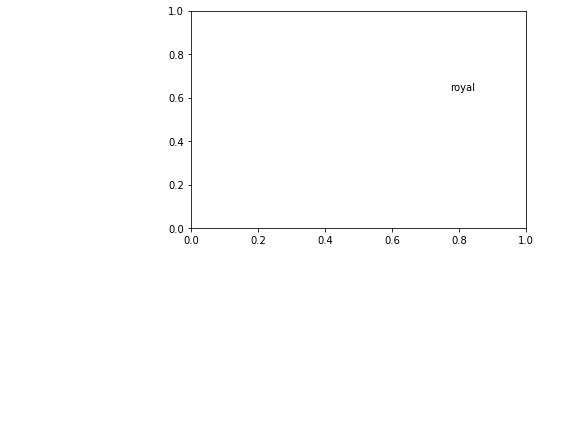

In [ ]:
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index


from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors) 

from sklearn import preprocessing

normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

print(vectors)

import matplotlib.pyplot as plt


fig, ax = plt.subplots()
print(words)
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()

Of course the accuracy of such system is not be trusted. In real use case we are gonna use pre trained models with gensim.

In [ ]:
! pip install gensim

### Word embeddings through gensim

In [ ]:
from gensim.models import Word2Vec
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['final'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=14, size=100, alpha=0.025)
['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec', 'second', 'yet', 'another', 'one', 'more', 'and', 'final']
[-3.7835222e-03  2.0042905e-03  2.2990281e-04 -1.2208561e-03
 -4.3613871e-04 -3.9045967e-03  1.8054344e-03  2.5673355e-03
 -4.6929019e-03 -4.1167387e-03  1.2083285e-03 -2.6660601e-03
 -4.8384257e-03 -2.0087021e-03  4.9847050e-04  4.3706466e-03
  1.2724249e-03  4.6071722e-03  3.7176907e-04 -4.7008391e-03
  4.1795443e-03 -4.1248244e-03  4.7084494e-03  2.6264584e-03
 -3.7582852e-03 -1.3030982e-03 -2.9409081e-03  3.2188206e-03
 -1.7577367e-03 -1.7908795e-03 -3.8229092e-03  3.9482652e-03
 -3.1740188e-03 -1.5365714e-04  1.4529527e-03 -1.8598282e-03
 -4.5641270e-03  9.7837776e-04 -3.4167115e-03 -3.6915860e-04
  3.5106556e-03 -3.1095644e-04  7.5340807e-04  2.1802206e-03
 -1.2776522e-03 -6.2929542e-04  2.6486928e-03 -1.0675847e-03
 -1.2619243e-03  2.9710548e-03  2.8953357e-03 -1.1400762e-03
  3.1337931e-03  3.5828641e-03  1.8869299e-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [ ]:
print(new_model["first"])

[ 2.5503116e-03  2.6400078e-03 -2.4497060e-03 -5.3572422e-04
 -2.0325491e-03  1.5541700e-03 -4.7720405e-03 -2.7276126e-03
 -4.9316864e-03  2.6270316e-03  6.5080414e-04  3.7766586e-03
  2.9760334e-03 -9.6039858e-04 -4.8139780e-03  2.2456320e-03
 -1.9232357e-03  3.4962061e-03  3.1506659e-03 -3.6613856e-04
 -4.5635967e-04 -1.5396453e-03  4.0826248e-03  4.4814050e-03
 -4.7537172e-03  1.5954729e-03 -1.1576893e-03  3.2201568e-03
  1.9953232e-03  3.1332471e-04  3.7847918e-03  2.9944268e-03
  2.9732906e-03 -4.9394788e-03  3.7500006e-03 -4.9902298e-03
  1.1157364e-03 -3.4418805e-03  1.4733846e-04 -3.8336741e-03
  8.1489276e-04 -7.1118376e-04  1.6997654e-04  4.6202186e-03
 -4.2982437e-03 -7.8105228e-04  9.0875692e-04  1.2465660e-03
 -7.6181738e-04 -2.6440229e-03  2.9233512e-03 -4.9969540e-03
  2.4358269e-03 -1.9439070e-03 -1.2246319e-03  4.3208352e-03
  2.5429862e-04  4.6977980e-04  2.0287214e-03  1.4854773e-03
  4.3482394e-03  1.6895226e-03 -3.2056300e-03  4.3232176e-03
  4.3138820e-03  1.91402

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


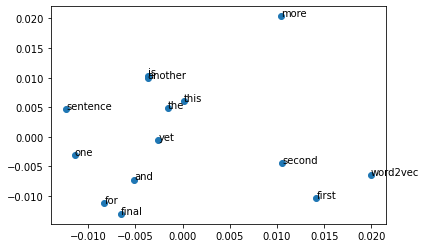

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec(sentences, min_count=1)
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

Training your own word vectors may be the best approach for a given NLP problem.

But it can take a long time, a fast computer with a lot of RAM and disk space, and perhaps some expertise in finessing the input data and training algorithm.

An alternative is to simply use an existing pre-trained word embedding.

Along with the paper and code for word2vec, Google also published a pre-trained word2vec model on the Word2Vec Google Code Project.

A pre-trained model is nothing more than a file containing tokens and their associated word vectors. The pre-trained Google word2vec model was trained on Google news data (about 100 billion words); it contains 3 million words and phrases and was fit using 300-dimensional word vectors.

It is a 1.53 Gigabytes file. You can download it from here:

[GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)

Unzipped, the binary file (GoogleNews-vectors-negative300.bin) is 3.4 Gigabytes.

The Gensim library provides tools to load this file. Specifically, you can call the KeyedVectors.load_word2vec_format() function to load this model into memory

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin' # need to have this file locally
model = KeyedVectors.load_word2vec_format(filename, binary=True)

model = KeyedVectors.load_word2vec_format(filename, binary=True)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

FileNotFoundError: ignored

### GloVe

Stanford researchers also have their own word embedding algorithm like word2vec called Global Vectors for Word Representation, or GloVe for short.

Like word2vec, the GloVe researchers also provide pre-trained word vectors, in this case, a great selection to choose from.

You can download the GloVe pre-trained word vectors and load them easily with gensim.

The first step is to convert the GloVe file format to the word2vec file format. The only difference is the addition of a small header line. This can be done by calling the glove2word2vec() function

You can download the smallest GloVe pre-trained model from the GloVe website. It an 822 Megabyte zip file with 4 different models (50, 100, 200 and 300-dimensional vectors) trained on Wikipedia data with 6 billion tokens and a 400,000 word vocabulary.

The direct download link is here:

[glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip)

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt' # need to have this file locally
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

You now have a copy of the GloVe model in word2vec format with the filename glove.6B.100d.txt.word2vec.

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)